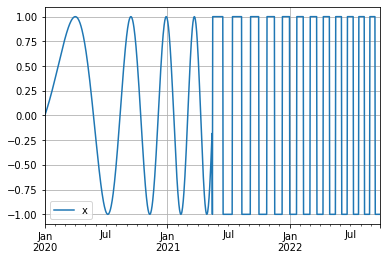

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def cuadrada(x,a=1):
  Y=np.sin(x)
  s=[]
  for y in Y:
    if y<0:
      s.append(-a)
    elif y>0:
      s.append(a)
  return np.array(s)
N=1000
t=pd.date_range('2020-01-01',periods=N)
w1=np.linspace(0.01,0.05,N//2)
w2=np.linspace(0.05,0.1,N//2)

x1=np.sin(w1*np.arange(N//2))
x2=cuadrada(w2*np.arange(N//2+1,N+1))
x=np.concatenate([x1,x2])
st=pd.DataFrame(index=t,data=x,columns=['x'])
st.plot(grid=True)

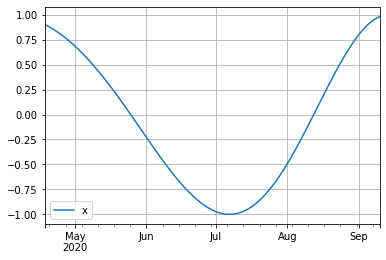

In [4]:
# Inicialización de parámetros de la shapelet candidata
w=np.random.randint(50,200)
i=np.random.randint(0,N-w)
s=st[i:i+w]
s.plot(grid=True)

In [5]:
from scipy.stats import zscore

In [35]:
# Encontramos la relación entre la shapelet candidata y la serie de tiempo
#
# Definimos la métrica
def C(a,b):   # Correlación ('a' y 'b' de longitud 'm')
  m=len(a)
  ma=np.mean(a)
  mb=np.mean(b)
  sa=np.std(a)
  sb=np.std(b)
  return (np.sum(a*b)-m*ma*mb)/(m*sa*sb)
def d(a,b):   # distancia (métrica)
  a=zscore(a)
  b=zscore(b)
  return np.sqrt(2*(1-np.round(C(a,b),5)))

In [36]:
m=100
a=np.random.rand(m)
b=np.random.rand(m)
d(a,b)

1.4280686258019955

In [17]:
d(a,2*a)

0.0

In [37]:
np.round(C(a,2*a),5)

1.0

In [38]:
def C(a,b): # Correlación ('a' y 'b' tienen diferente longitud)
  m=min(len(a),len(b))
  n=max(len(a),len(b))
  if len(a)>len(b):
    B=a
    A=b
  else:
    B=b
    A=a
  ma=np.mean(A)
  mb=np.mean(B)
  sa=np.std(A)
  sb=np.std(B)
  Corr=np.inf
  for l in range(n-m):
    Corr=min(Corr,(np.sum(A*B[l:l+m])-m*ma*mb)/(m*sa*sb))
  return Corr

In [39]:
a=np.random.rand(100)
b=np.random.rand(150)
d(a,b)

1.531809387619752

In [41]:
a=np.random.rand(150)
b=np.random.rand(100)
d(a,b)

1.6080609441187235

In [42]:
from scipy.optimize import minimize_scalar

In [43]:
minimize_scalar?

In [44]:
d(s['x'],st['x'])

1.916110643986928

In [45]:
def obj(i,st):
  i=int(np.round(i))
  s=st[i:i+w]
  return d(s,st)

In [46]:
obj(i,st['x'])

1.916110643986928

In [58]:
# Modificar el valor de w
w=100

In [59]:
sol=minimize_scalar(obj,bounds=(0,N-w),method='Bounded',args=(st['x'],))
sol

     fun: 1.896417675513493
 message: 'Solution found.'
    nfev: 36
  status: 0
 success: True
       x: 209.6661185263728

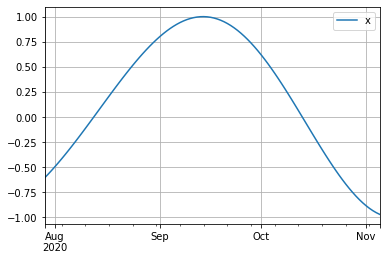

In [60]:
i1=int(np.round(sol.x))
s1=st[i1:i1+w]
s1.plot(grid=True)

In [61]:
sol2=minimize_scalar(obj,bounds=(0,i1-w),method='Bounded',args=(st['x'],)) # Buscamos por la izquierda de la primera shapelet
i2=int(np.round(sol2.x))
i2,sol2.fun

(42, 1.871982905904859)

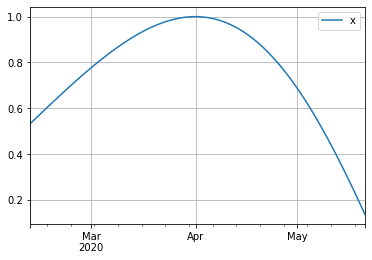

In [62]:
s2=st[i2:i2+w]
s2.plot(grid=True)

In [63]:
sol3=minimize_scalar(obj,bounds=(i1+w,N-w),method='Bounded',args=(st['x'],))
i3=int(np.round(sol3.x))
i3,sol3.fun

(674, 2.019925741209315)

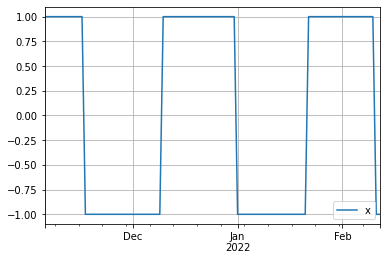

In [64]:
s3=st[i3:i3+w]
s3.plot(grid=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

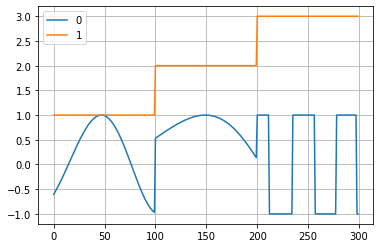

In [76]:
# Diccionario de patrones
#
# Escogemos s2 y s3 para clasificar 'st'
s1['clase']=1
s2['clase']=2
s3['clase']=3
S=np.concatenate([s1.values,s2.values,s3.values])
S=pd.DataFrame(S)
S.plot(grid=True)

In [77]:
S.columns=['x','clase']

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
dtc=DecisionTreeClassifier(max_depth=5)
dtc.fit(S[['x']],S['clase'])

DecisionTreeClassifier(max_depth=5)

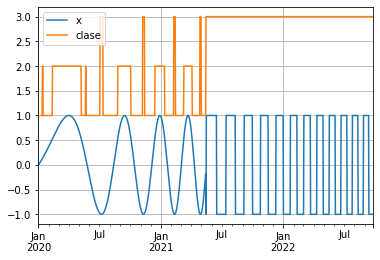

In [79]:
st['clase']=dtc.predict(st[['x']])
st.plot(grid=True)

In [80]:
st.groupby('clase')['x'].count()

clase
1.0    294
2.0    182
3.0    524
Name: x, dtype: int64